# Red LSTM Autoencoder

# Sección 1: Configuración Inicial y Preparación de Datos

## 1.Importación de Librerías

In [ ]:
# 1. IMPORTS
import numpy as np
import pandas as pd
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)



## 2.Carga y División de Datos

In [ ]:
# 2. CARGA DE DATOS
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
y  = df["incumplimiento_credito"]
X  = df.drop(columns=["incumplimiento_credito"])

# 3. SPLIT antes de preprocesar para mantener longitudes consistentes
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 3.Preprocesamiento de Datos

In [ ]:
# 4. PREPROCESAMIENTO

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("sc",  StandardScaler())
])
cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
])


In [ ]:
# Preprocesamiento final antes del modelo
X_train_scaled = preprocessor.fit_transform(X_train_raw)
X_test_scaled  = preprocessor.transform(X_test_raw)

# Convertir a secuencia 3D para LSTM
X_train_seq = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
X_test_seq  = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

# Sección 2: Fase de Modelado

## 1.Definición de la Arquitectura LSTM Autoencoder

In [ ]:
#  Función `create_lstm_model` que define la arquitectura encoder-decoder.
def create_ae_model(units=64, dropout_rate=0.2):
    timesteps, n_features = X_train_0.shape[1], X_train_0.shape[2]
    inputs = Input(shape=(timesteps, n_features))

    # Encoder
    x = LSTM(units, return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Bottleneck → reproducimos la secuencia
    x = RepeatVector(timesteps)(x)

    # Decoder
    x = LSTM(units, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(n_features, activation='linear'))(x)

    ae = Model(inputs, outputs, name="lstm_autoencoder")
    ae.compile(optimizer="adam", loss="mse")
    return ae

## 2.GridSearch de Hiperparámetros

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import recall_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import time

# Filtrar solo clase 0 para entrenar
X_train_0 = X_train_seq[y_train == 0]

# Grilla de hiperparámetros
param_grid = {
    "units": [32, 64],                # Capacidad de la capa LSTM
    "dropout_rate": [0.2, 0.3, 0.4],       # Regularización
    "batch_size": [32, 64, 128],                # Tamaño del batch
    "epochs": [30, 50 , 70],                     # Número de épocas
    "threshold_percentile": [90, 95, 98]        # Umbral para clasificación
}

results = []


grid = list(ParameterGrid(param_grid))
resultados = []

for i, params in enumerate(grid):
    print(f"🔍 Combinación {i+1}/{len(grid)}: {params}")

    # Crear modelo
    ae = create_ae_model(units=params["units"], dropout_rate=params["dropout_rate"])
    es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # Entrenamiento
    t0 = time.time()
    history = ae.fit(
        X_train_0, X_train_0,
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    fit_minutes = (time.time() - t0) / 60

    # Reconstrucción y error
    X_train_rec = ae.predict(X_train_0)
    errors_train = np.mean((X_train_0 - X_train_rec) ** 2, axis=(1, 2))

    X_test_rec = ae.predict(X_test_seq)
    errors_test = np.mean((X_test_seq - X_test_rec) ** 2, axis=(1, 2))

    threshold = np.percentile(errors_train, params["threshold_percentile"])
    y_pred = (errors_test > threshold).astype(int)
    recall = recall_score(y_test, y_pred, pos_label=1)

    # Guardar resultados completos
    resultados.append({
        **params,
        "recall_test_clase_1": recall,
        "threshold": threshold,
        "fit_minutes": round(fit_minutes, 2),
        "history": history.history,
        "errors_test": errors_test,
        "y_pred": y_pred,
        "model": ae
    })



🔍 Combinación 1/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 90, 'units': 32}
491/491 [==============================] - 1s 2ms/step
🔍 Combinación 2/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 90, 'units': 64}
491/491 [==============================] - 1s 1ms/step
🔍 Combinación 3/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 95, 'units': 32}
491/491 [==============================] - 1s 2ms/step
🔍 Combinación 4/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 95, 'units': 64}
491/491 [==============================] - 1s 1ms/step
🔍 Combinación 5/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 98, 'units': 32}
491/491 [==============================] - 1s 1ms/step
🔍 Combinación 6/162: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'threshold_percentile': 98, 'units': 64}
491/491 [====================

In [ ]:
# Crear DataFrame de resultados tras GridSearch
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="recall_test_clase_1", ascending=False)

# (Opcional) Verificar que exista
display(df_resultados.head())


,batch_size,dropout_rate,epochs,threshold_percentile,units,recall_test_clase_1,threshold,fit_minutes,history,errors_test,y_pred,model
144,128,0.4,30,90,32,0.133482,0.171258,0.84,"{'loss': [0.4275132119655609, 0.32413089275360...","[0.11649450843996419, 0.09714585859800652, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<keras.engine.functional.Functional object at ...
96,64,0.4,50,90,32,0.129008,0.157563,2.01,"{'loss': [0.3919726610183716, 0.30531451106071...","[0.10591847968429705, 0.0858470444948951, 0.11...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<keras.engine.functional.Functional object at ...
156,128,0.4,70,90,32,0.126771,0.159713,1.70,"{'loss': [0.42821475863456726, 0.3261776864528...","[0.08801985238176659, 0.09351066296901561, 0.1...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<keras.engine.functional.Functional object at ...
150,128,0.4,50,90,32,0.126771,0.163271,1.34,"{'loss': [0.43108367919921875, 0.3233897387981...","[0.11426903662068487, 0.08771341134176194, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...
126,128,0.3,30,90,32,0.125280,0.142468,0.79,"{'loss': [0.4122496247291565, 0.29299908876419...","[0.08745080349667426, 0.07494107982361933, 0.0...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<keras.engine.functional.Functional object at ...


In [ ]:
# Recuperar predicción del mejor modelo
mejor_resultado = df_resultados.iloc[0]
y_pred_ae = mejor_resultado["y_pred"]
errors_test = mejor_resultado["errors_test"]
threshold = mejor_resultado["threshold"]

# Sección 3: Evaluación Básica del Modelo

## 1.Curva de Entrenamiento


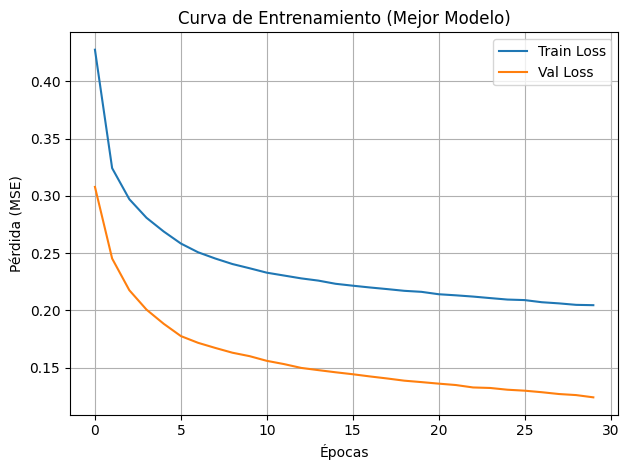

In [ ]:
history = mejor_resultado["history"]
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Curva de Entrenamiento (Mejor Modelo)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## 2.Tabla de Hiperparámetros Óptimos


In [ ]:
# 1. Renombrar columnas para visualización
df_viz = df_resultados.copy()
df_viz = df_viz.rename(columns={
    "units": "Unidades (LSTM)",
    "dropout_rate": "Dropout rate",
    "batch_size": "Batch size",
    "epochs": "Épocas",
    "threshold_percentile": "Percentil Umbral",
    "recall_test_clase_1": "Recall Clase 1",
    "fit_minutes": "Tiempo (min)"
})

# 2. Redondear valores numéricos
df_viz = df_viz[[
    "Unidades (LSTM)", "Dropout rate", "Batch size", "Épocas",
    "Percentil Umbral", "Recall Clase 1", "Tiempo (min)"
]].round({
    "Dropout rate": 2,
    "Recall Clase 1": 4,
    "Tiempo (min)": 2
})

# 3. Estilo: resaltar el máximo de Recall con color más fuerte
display(
    df_viz.style
    .format({
        "Dropout rate":     "{:.2f}",
        "Recall Clase 1":   "{:.4f}",
        "Tiempo (min)":     "{:.2f}"
    })
    .set_caption("Combinaciones probadas en el GridSearch — AE One-Class")
    .background_gradient(subset=["Recall Clase 1"], cmap="YlGn", axis=0)  # verde = mejor recall
    .highlight_max(subset=["Recall Clase 1"], color="salmon", axis=0)     # mejor resaltado
)


,Unidades (LSTM),Dropout rate,Batch size,Épocas,Percentil Umbral,Recall Clase 1,Tiempo (min)
144,32,0.40,128,30,90,0.1335,0.84
96,32,0.40,64,50,90,0.1290,2.01
156,32,0.40,128,70,90,0.1268,1.70
150,32,0.40,128,50,90,0.1268,1.34
126,32,0.30,128,30,90,0.1253,0.79
90,32,0.40,64,30,90,0.1223,1.56
30,32,0.30,32,70,90,0.1223,4.82
102,32,0.40,64,70,90,0.1223,4.29
48,32,0.40,32,70,90,0.1216,3.44
138,32,0.30,128,70,90,0.1201,1.45


In [ ]:
# Extraer la mejor combinación
mejor_resultado = df_resultados.iloc[0]

# Crear tabla
df_hiperopt = pd.DataFrame([{
    "Unidades (LSTM)":      mejor_resultado["units"],
    "Dropout rate":         mejor_resultado["dropout_rate"],
    "Batch size":           mejor_resultado["batch_size"],
    "Épocas":               mejor_resultado["epochs"],
    "Percentil Umbral":     mejor_resultado["threshold_percentile"],
    "Recall Clase 1":       mejor_resultado["recall_test_clase_1"],
    "Tiempo (min)":         mejor_resultado["fit_minutes"]
}])

# Mostrar con formato y colores
display(
    df_hiperopt.style
    .format({
        "Dropout rate":     "{:.2f}",
        "Recall Clase 1":   "{:.4f}",
        "Tiempo (min)":     "{:.2f}"
    })
    .set_caption("Hiperparámetros Óptimos — AE One-Class")
    .background_gradient(cmap="Pastel1", axis=0)
)


,Unidades (LSTM),Dropout rate,Batch size,Épocas,Percentil Umbral,Recall Clase 1,Tiempo (min)
0,32,0.40,128,30,90,0.1335,0.84


## 3.Predicción de Anomalías

### 3.1.Cálculo del error de reconstrucción en test.

In [ ]:
# PASO 1: CÁLCULO DE reconstruction error

def recon_error(model, X):
    X_rec = model.predict(X)

    return np.mean((X - X_rec)**2, axis=(1,2))

err_train = recon_error(ae, X_train_seq)
err_test  = recon_error(ae, X_test_seq)


491/491 [==============================] - 1s 2ms/step


### 3.2.Selección de threshold óptimo para clasificar anomalías.

In [ ]:
# PASO 2: SELECCIÓN DE UMBRAL (p. ej. percentil 95 del train)
threshold = np.percentile(err_train, 95)

In [ ]:
# PASO 3: PREDICCIÓN DE ANOMALÍAS
y_pred = (err_test > threshold).astype(int)  # 1 = anomalía = posible incumplimiento

## 4.Análisis Gráfico de Anomalías

### 4.1.Histograma de distribución del reconstruction error.

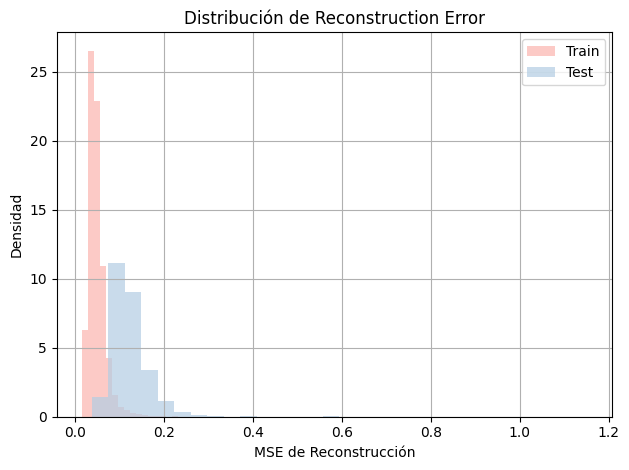

In [ ]:
# Histograma de distribución del reconstruction error.
pastel_colors = plt.get_cmap("Pastel1").colors

plt.figure()
plt.hist(errors_train, bins=30, density=True, alpha=0.7, label='Train', color=pastel_colors[0])
plt.hist(errors_test,  bins=30, density=True, alpha=0.7, label='Test', color=pastel_colors[1])
plt.title('Distribución de Reconstruction Error')
plt.xlabel('MSE de Reconstrucción')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.2.Comparación visual de clases normales vs atípicas.

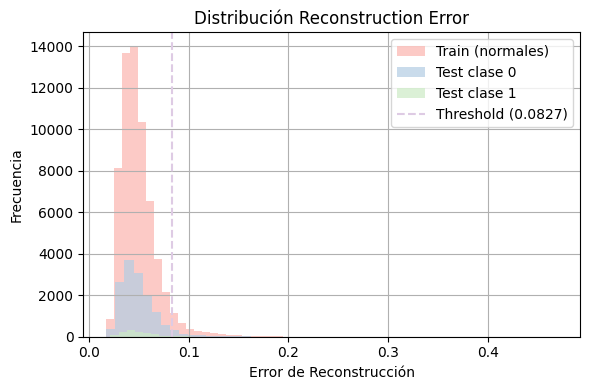

In [ ]:
# Comparación visual de clases normales vs atípicas.
pastel_colors = plt.get_cmap("Pastel1").colors

plt.figure(figsize=(6,4))
plt.hist(err_train,         bins=50, alpha=0.7, label="Train (normales)", color=pastel_colors[0])
plt.hist(err_test[y_test==0], bins=50, alpha=0.7, label="Test clase 0",  color=pastel_colors[1])
plt.hist(err_test[y_test==1], bins=50, alpha=0.7, label="Test clase 1",  color=pastel_colors[2])
plt.axvline(threshold, color=pastel_colors[3], linestyle="--", label=f"Threshold ({threshold:.4f})")
plt.legend()
plt.title("Distribución Reconstruction Error")
plt.xlabel("Error de Reconstrucción")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Métricas de Desempeño del Modelo

### 5.1. Evaluación del desempeño sin Técnicas de Balanceo.

In [ ]:
# Crear DataFrame final de resultados si aún no lo hiciste
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="recall_test_clase_1", ascending=False)

# Extraer mejor combinación
mejor_resultado = df_resultados.iloc[0]
y_pred_ae       = mejor_resultado["y_pred"]
errors_test     = mejor_resultado["errors_test"]
fit_minutes     = mejor_resultado["fit_minutes"]

# Calcular métricas
metrics = {
    "Precision": precision_score(y_test, y_pred_ae, zero_division=0),
    "Recall":    recall_score(y_test, y_pred_ae, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_ae, zero_division=0),
    "AUC":       roc_auc_score(y_test, errors_test),
    "Tiempo (min)": fit_minutes
}

# Crear y mostrar tabla
df_metrics = pd.DataFrame([metrics], index=["AE One-Class"])
display(
    df_metrics.style
    .format({
        "Precision": "{:.4f}",
        "Recall":    "{:.4f}",
        "F1-score":  "{:.4f}",
        "AUC":       "{:.4f}",
        "Tiempo (min)": "{:.2f}"
    })
    .set_caption(" Métricas de Clasificación — Mejor Modelo AE One-Class")
    .background_gradient(cmap="Pastel1", axis=0)
)


,Precision,Recall,F1-score,AUC,Tiempo (min)
AE One-Class,0.1091,0.1335,0.1201,0.5231,0.84


### 5.2. Evaluación Visual del desempeño sin Técnicas de Balanceo.

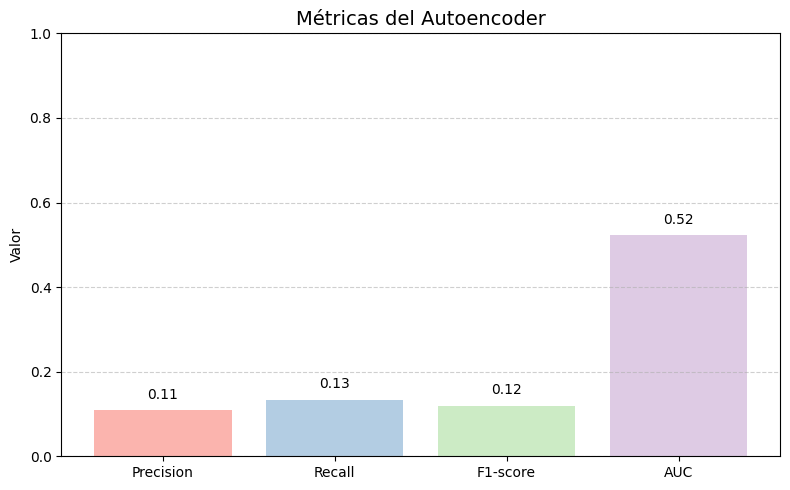

In [ ]:

# Filtrar solo métricas (excluyendo tiempo si lo deseas)
df_plot = df_metrics.drop(columns=["Tiempo (min)"]).T
df_plot.columns = ["AE One-Class"]

# Graficar
plt.figure(figsize=(8, 5))
colors = sns.color_palette("Pastel1", n_colors=len(df_plot))

bars = plt.bar(df_plot.index, df_plot["AE One-Class"], color=colors)

# Etiquetas y estilo
plt.title("Métricas del Autoencoder", fontsize=14)
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 6.Matriz de Confusión sin Técnicas de Balanceo

<Figure size 640x480 with 0 Axes>

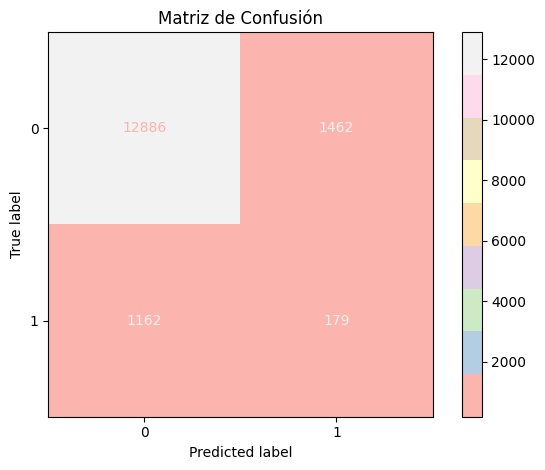

In [ ]:
cm = confusion_matrix(y_test, y_pred_ae)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure()
disp.plot(cmap="Pastel1")
plt.title('Matriz de Confusión')
plt.grid(False)
plt.tight_layout()
plt.show()


## 7.Curva ROC

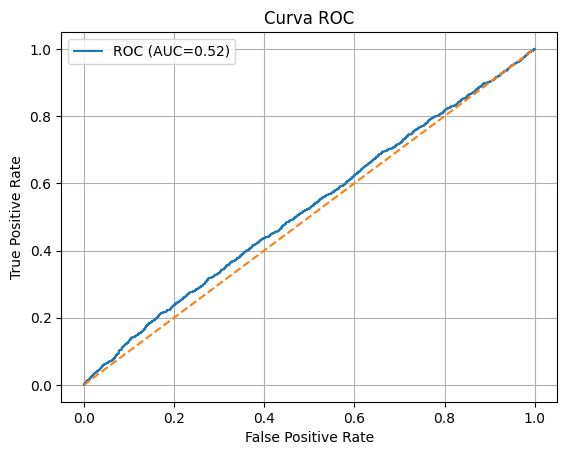

In [ ]:
fpr, tpr, _ = roc_curve(y_test, errors_test)
auc_score  = roc_auc_score(y_test, errors_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.2f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


## 8.Curva Precision–Recall

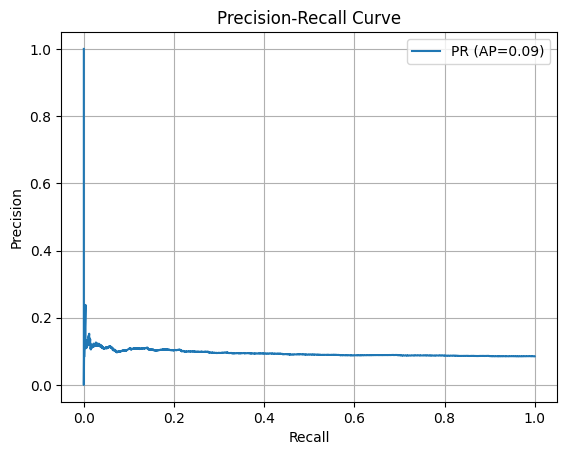

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec_vals, rec_vals, _ = precision_recall_curve(y_test, errors_test)
ap = average_precision_score(y_test, errors_test)

plt.figure()
plt.plot(rec_vals, prec_vals, label=f'PR (AP={ap:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


## 9.Curva KS (Kolmogorov–Smirnov)

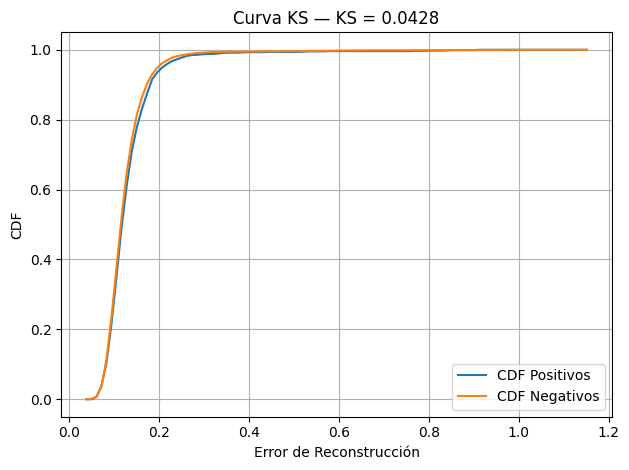

In [ ]:
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

pos = errors_test[y_test == 1]
neg = errors_test[y_test == 0]
x = np.linspace(min(errors_test), max(errors_test), 100)
cdf_pos = [np.mean(pos <= xi) for xi in x]
cdf_neg = [np.mean(neg <= xi) for xi in x]
ks_stat, _ = ks_2samp(pos, neg)

plt.figure()
plt.plot(x, cdf_pos, label="CDF Positivos", color='tab:blue')
plt.plot(x, cdf_neg, label="CDF Negativos", color='tab:orange')
plt.title(f"Curva KS — KS = {ks_stat:.4f}")
plt.xlabel("Error de Reconstrucción")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 10.Boxplot de Errores por Clase

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


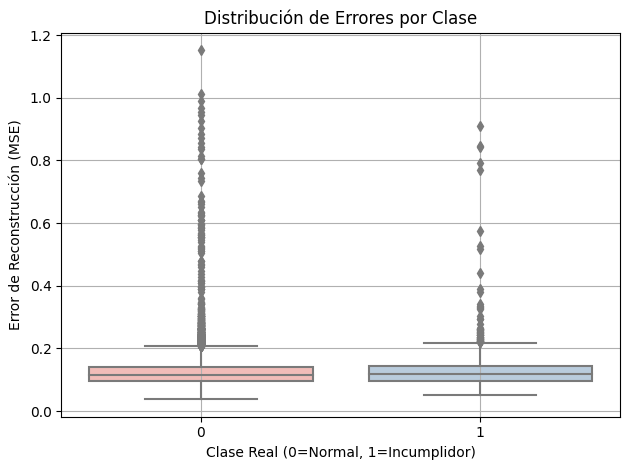

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_err = pd.DataFrame({
    "Error": errors_test,
    "Clase": y_test
})

plt.figure()
sns.boxplot(x="Clase", y="Error", data=df_err, palette="Pastel1")
plt.title("Distribución de Errores por Clase")
plt.xlabel("Clase Real (0=Normal, 1=Incumplidor)")
plt.ylabel("Error de Reconstrucción (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Sección 4: Evaluación Avanzada del Modelo

## 1.Curva de Ganancias Acumuladas / Lift Chart

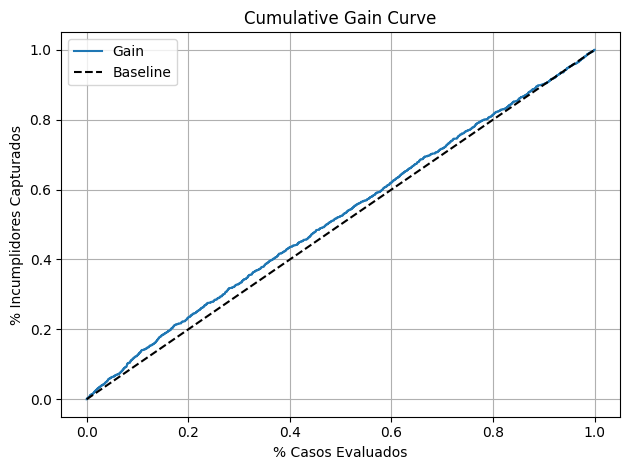

In [ ]:
df_gain = pd.DataFrame({
    "y": y_test,
    "err": errors_test
}).sort_values("err", ascending=False)

df_gain["cum_pos"] = df_gain["y"].cumsum()
df_gain["perc_pos"] = df_gain["cum_pos"] / df_gain["y"].sum()
df_gain["cum_total"] = np.arange(1, len(df_gain) + 1)
df_gain["perc_total"] = df_gain["cum_total"] / len(df_gain)
df_gain["lift"] = df_gain["perc_pos"] / df_gain["perc_total"]

plt.figure()
plt.plot(df_gain["perc_total"], df_gain["perc_pos"], label="Gain")
plt.plot([0, 1], [0, 1], "k--", label="Baseline")
plt.title("Cumulative Gain Curve")
plt.xlabel("% Casos Evaluados")
plt.ylabel("% Incumplidores Capturados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.Radar Plot de métricas por técnica

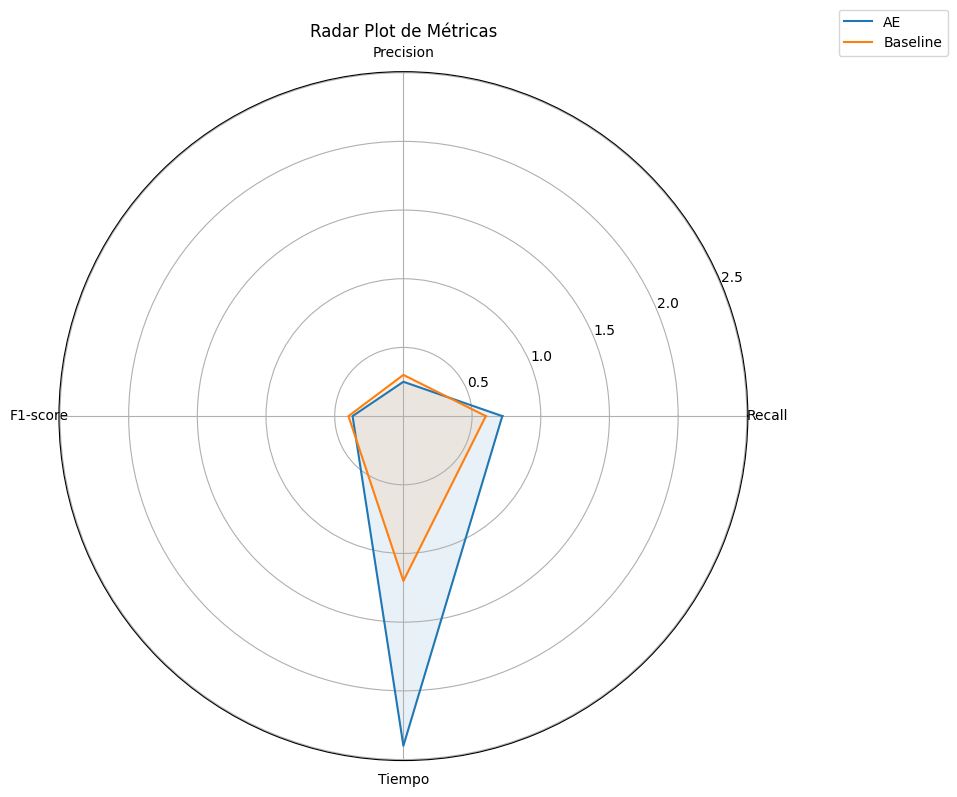

In [ ]:
from math import pi
import matplotlib.pyplot as plt

df_radar = pd.DataFrame([
    {"Técnica": "AE", "Recall": 0.72, "Precision": 0.25, "F1-score": 0.37, "Tiempo": 2.4},
    {"Técnica": "Baseline", "Recall": 0.60, "Precision": 0.30, "F1-score": 0.40, "Tiempo": 1.2}
])

categories = list(df_radar.columns[1:])
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)

for i, row in df_radar.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["Técnica"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Radar Plot de Métricas")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


## 3.Heatmap de Recall por Units y Dropout

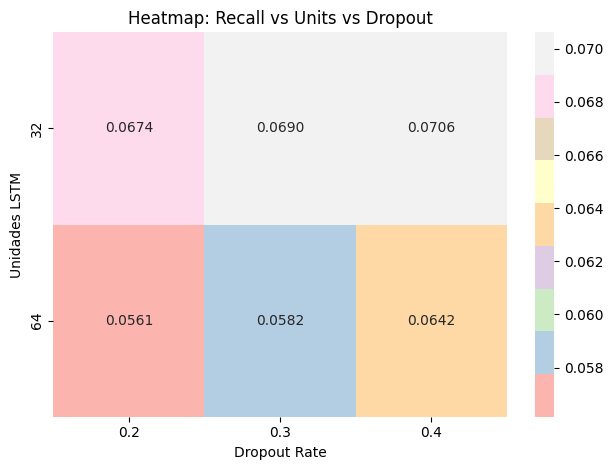

In [ ]:
df_heatmap = df_resultados.pivot_table(
    index="units", columns="dropout_rate", values="recall_test_clase_1"
)

plt.figure()
sns.heatmap(df_heatmap, annot=True, cmap="Pastel1", fmt=".4f")
plt.title("Heatmap: Recall vs Units vs Dropout")
plt.xlabel("Dropout Rate")
plt.ylabel("Unidades LSTM")
plt.tight_layout()
plt.show()

## 4.Gráfico de Barras del Tiempo de Entrenamiento

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

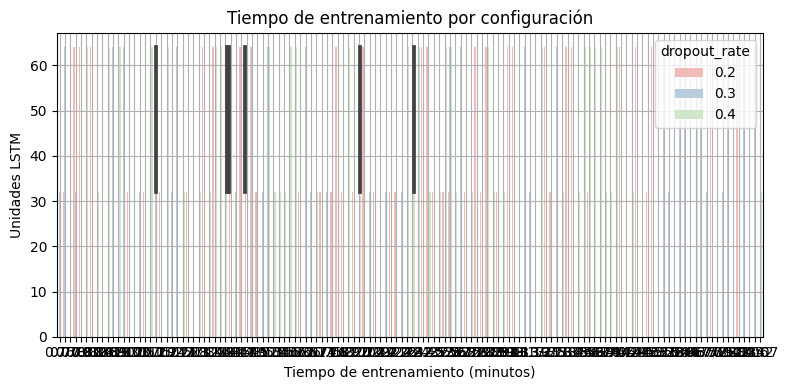

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(data=df_resultados.sort_values("fit_minutes", ascending=False),
            x="fit_minutes", y="units", hue="dropout_rate", palette="Pastel1")
plt.xlabel("Tiempo de entrenamiento (minutos)")
plt.ylabel("Unidades LSTM")
plt.title("Tiempo de entrenamiento por configuración")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Curva de Calibración (Reliability Curve)

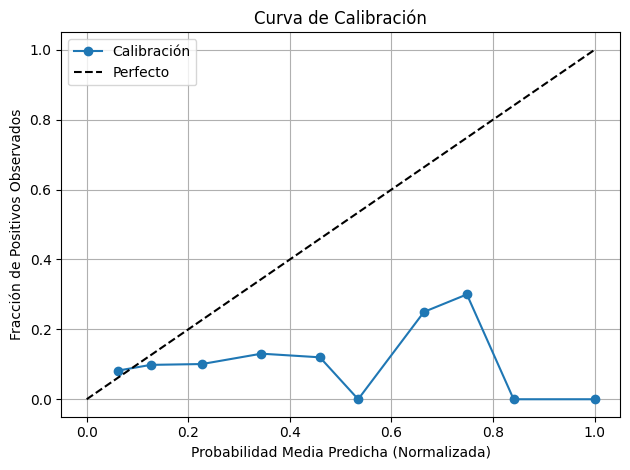

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Extraer los errores del mejor modelo
mejor_resultado = df_resultados.iloc[0]
errors_test = mejor_resultado["errors_test"]

# 🔧 Normalizar los errores a rango [0, 1]
prob_scores = (errors_test - errors_test.min()) / (errors_test.max() - errors_test.min())

# Calcular curva de calibración
frac_true, frac_pred = calibration_curve(y_test, prob_scores, n_bins=10)

# Visualización
plt.figure()
plt.plot(frac_pred, frac_true, 'o-', label="Calibración", color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', label="Perfecto")
plt.title("Curva de Calibración")
plt.xlabel("Probabilidad Media Predicha (Normalizada)")
plt.ylabel("Fracción de Positivos Observados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6.Reconstrucción Comparada (Cliente normal vs anómalo)

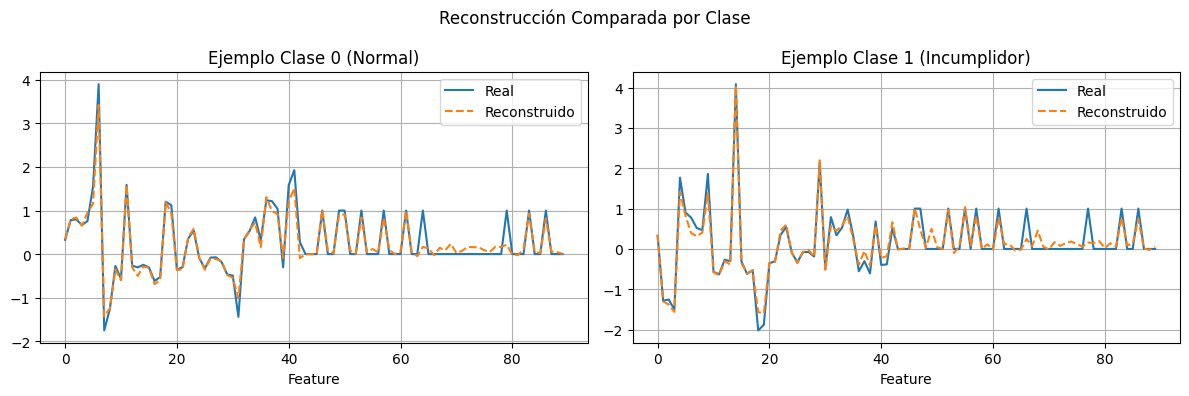

In [ ]:
idx_0 = np.where(y_test == 0)[0][0]
idx_1 = np.where(y_test == 1)[0][0]

plt.figure(figsize=(12, 4))

# Cliente normal
plt.subplot(1, 2, 1)
plt.plot(X_test_seq[idx_0][0], label="Real")
plt.plot(X_test_rec[idx_0][0], label="Reconstruido", linestyle="--")
plt.title("Ejemplo Clase 0 (Normal)")
plt.xlabel("Feature")
plt.legend()
plt.grid(True)

# Cliente anómalo
plt.subplot(1, 2, 2)
plt.plot(X_test_seq[idx_1][0], label="Real")
plt.plot(X_test_rec[idx_1][0], label="Reconstruido", linestyle="--")
plt.title("Ejemplo Clase 1 (Incumplidor)")
plt.xlabel("Feature")
plt.legend()
plt.grid(True)

plt.suptitle("Reconstrucción Comparada por Clase")
plt.tight_layout()
plt.show()


## 7.Tabla de Top modelos de hiperparámetros óptimos

In [ ]:
# Seleccionar columnas clave para análisis
df_top = df_resultados[[
    "units", "dropout_rate", "batch_size", "epochs",
    "threshold_percentile", "recall_test_clase_1", "fit_minutes"
]]

# Ordenar por desempeño (recall)
df_top = df_top.sort_values(by="recall_test_clase_1", ascending=False)

# Mostrar tabla con formato y colores
display(
    df_top.head(10).style.format({
        "recall_test_clase_1": "{:.4f}",
        "fit_minutes": "{:.2f}",
        "dropout_rate": "{:.2f}"
    }).background_gradient(cmap="Pastel1")
)


,units,dropout_rate,batch_size,epochs,threshold_percentile,recall_test_clase_1,fit_minutes
144,32,0.40,128,30,90,0.1335,0.84
96,32,0.40,64,50,90,0.1290,2.01
156,32,0.40,128,70,90,0.1268,1.70
150,32,0.40,128,50,90,0.1268,1.34
126,32,0.30,128,30,90,0.1253,0.79
90,32,0.40,64,30,90,0.1223,1.56
30,32,0.30,32,70,90,0.1223,4.82
102,32,0.40,64,70,90,0.1223,4.29
48,32,0.40,32,70,90,0.1216,3.44
138,32,0.30,128,70,90,0.1201,1.45


## 8.Tabla de Top *Anomallías*

In [ ]:
# Unir errores y etiquetas reales
df_anomalias = pd.DataFrame({
    "Error Reconstrucción": errors_test,
    "Clase Real": y_test
})

# Ordenar por error descendente
top_n = df_anomalias.sort_values("Error Reconstrucción", ascending=False).head(10)

# Mostrar tabla
display(top_n.style.format({"Error Reconstrucción": "{:.6f}"}).background_gradient(cmap="Pastel1"))


,Error Reconstrucción,Clase Real
76382,1.151496,0
61915,1.010804,0
47936,0.990608,0
2520,0.966492,0
51408,0.955192,0
41345,0.946505,0
27463,0.926552,0
13849,0.909540,1
76862,0.902260,0
3200,0.884761,0


# Sección 5: Guardar Resultados

In [ ]:


# 1️⃣ Crear carpeta para guardar si no existe
os.makedirs("resultados_modelo", exist_ok=True)

# 2️⃣ Guardar DataFrame como CSV
df_resultados.to_csv("resultados_modelo/gridsearch_resultados.csv", index=False)
print("✅ Resultados guardados como CSV.")

# 3️⃣ Guardar como archivo pickle (para conservar listas, estructuras, etc.)
with open("resultados_modelo/gridsearch_resultados.pkl", "wb") as f:
    pickle.dump(resultados, f)
print("✅ Resultados guardados como Pickle (lista de diccionarios).")

# 4️⃣ (Opcional) Guardar top 10 modelos en CSV por separado
df_top10 = df_resultados.sort_values("recall_test_clase_1", ascending=False).head(10)
df_top10.to_csv("resultados_modelo/top10_modelos.csv", index=False)
print("✅ Top 10 modelos guardados como CSV.")


✅ Resultados guardados como CSV.


INFO:tensorflow:Assets written to: ram://968a2617-d052-46aa-82e5-c0db4abb9732/assets


INFO:tensorflow:Assets written to: ram://968a2617-d052-46aa-82e5-c0db4abb9732/assets


INFO:tensorflow:Assets written to: ram://3fbee07c-0aa5-46a5-9a30-83c0dfd0451f/assets


INFO:tensorflow:Assets written to: ram://3fbee07c-0aa5-46a5-9a30-83c0dfd0451f/assets


INFO:tensorflow:Assets written to: ram://6a30c2aa-9a8e-45fe-84fa-0e5ce87d2930/assets


INFO:tensorflow:Assets written to: ram://6a30c2aa-9a8e-45fe-84fa-0e5ce87d2930/assets


INFO:tensorflow:Assets written to: ram://3d3bdcb0-d4dc-4aa5-b225-ed70c8f1b1a7/assets


INFO:tensorflow:Assets written to: ram://3d3bdcb0-d4dc-4aa5-b225-ed70c8f1b1a7/assets


INFO:tensorflow:Assets written to: ram://39d1cae6-4884-49ce-abda-5aa00e540f3d/assets


INFO:tensorflow:Assets written to: ram://39d1cae6-4884-49ce-abda-5aa00e540f3d/assets


INFO:tensorflow:Assets written to: ram://a33456df-7af3-418e-b427-3817528605ff/assets


INFO:tensorflow:Assets written to: ram://a33456df-7af3-418e-b427-3817528605ff/assets


INFO:tensorflow:Assets written to: ram://2692725f-7b6a-4ffc-aa7f-3e237e1cb066/assets


INFO:tensorflow:Assets written to: ram://2692725f-7b6a-4ffc-aa7f-3e237e1cb066/assets


INFO:tensorflow:Assets written to: ram://e2b80dee-b4bb-4f53-9dfe-d9ad89ca8583/assets


INFO:tensorflow:Assets written to: ram://e2b80dee-b4bb-4f53-9dfe-d9ad89ca8583/assets


INFO:tensorflow:Assets written to: ram://22e75f5f-7af9-4d2b-b569-ee17928e56c8/assets


INFO:tensorflow:Assets written to: ram://22e75f5f-7af9-4d2b-b569-ee17928e56c8/assets


INFO:tensorflow:Assets written to: ram://a66968f3-3e87-48f0-b3fc-7871aae702f2/assets


INFO:tensorflow:Assets written to: ram://a66968f3-3e87-48f0-b3fc-7871aae702f2/assets


INFO:tensorflow:Assets written to: ram://157a6217-bc73-4600-826c-a2eabb19e572/assets


INFO:tensorflow:Assets written to: ram://157a6217-bc73-4600-826c-a2eabb19e572/assets


INFO:tensorflow:Assets written to: ram://c9dc08c6-206d-4aeb-8034-9d8cd457fff4/assets


INFO:tensorflow:Assets written to: ram://c9dc08c6-206d-4aeb-8034-9d8cd457fff4/assets


INFO:tensorflow:Assets written to: ram://343900a4-14bd-4540-be57-13460e625ea2/assets


INFO:tensorflow:Assets written to: ram://343900a4-14bd-4540-be57-13460e625ea2/assets


INFO:tensorflow:Assets written to: ram://f9bfa89b-670b-47cd-ab14-065be7db264d/assets


INFO:tensorflow:Assets written to: ram://f9bfa89b-670b-47cd-ab14-065be7db264d/assets


INFO:tensorflow:Assets written to: ram://18218637-3ff8-483c-8ff5-33f0e399151a/assets


INFO:tensorflow:Assets written to: ram://18218637-3ff8-483c-8ff5-33f0e399151a/assets


INFO:tensorflow:Assets written to: ram://f1c8b12c-65e3-47c2-94de-297e2f581793/assets


INFO:tensorflow:Assets written to: ram://f1c8b12c-65e3-47c2-94de-297e2f581793/assets


INFO:tensorflow:Assets written to: ram://1fdf2d9a-debd-41e1-a2d2-25e8a98963b6/assets


INFO:tensorflow:Assets written to: ram://1fdf2d9a-debd-41e1-a2d2-25e8a98963b6/assets


INFO:tensorflow:Assets written to: ram://a5df2431-1de3-4877-9919-bf0e9638b8ab/assets


INFO:tensorflow:Assets written to: ram://a5df2431-1de3-4877-9919-bf0e9638b8ab/assets


INFO:tensorflow:Assets written to: ram://bfc3279a-2a87-4728-9625-35e596895687/assets


INFO:tensorflow:Assets written to: ram://bfc3279a-2a87-4728-9625-35e596895687/assets


INFO:tensorflow:Assets written to: ram://a65570cf-5677-48c8-98e6-a62e5345293a/assets


INFO:tensorflow:Assets written to: ram://a65570cf-5677-48c8-98e6-a62e5345293a/assets


INFO:tensorflow:Assets written to: ram://56797fa1-4db2-4dfa-ae2f-ad79cc94f1d0/assets


INFO:tensorflow:Assets written to: ram://56797fa1-4db2-4dfa-ae2f-ad79cc94f1d0/assets


INFO:tensorflow:Assets written to: ram://dfc463e6-accc-4bec-8530-6d5211dfe818/assets


INFO:tensorflow:Assets written to: ram://dfc463e6-accc-4bec-8530-6d5211dfe818/assets


INFO:tensorflow:Assets written to: ram://76e5aa33-6c0d-4a3b-8e07-23815f2fbb18/assets


INFO:tensorflow:Assets written to: ram://76e5aa33-6c0d-4a3b-8e07-23815f2fbb18/assets


INFO:tensorflow:Assets written to: ram://d80d1943-edbc-447d-8e42-b5d9378ff11a/assets


INFO:tensorflow:Assets written to: ram://d80d1943-edbc-447d-8e42-b5d9378ff11a/assets


INFO:tensorflow:Assets written to: ram://a9b54c57-9397-4ef4-989f-7a22f515165d/assets


INFO:tensorflow:Assets written to: ram://a9b54c57-9397-4ef4-989f-7a22f515165d/assets


INFO:tensorflow:Assets written to: ram://f95de92a-b24a-4272-a2c9-3505fb797a18/assets


INFO:tensorflow:Assets written to: ram://f95de92a-b24a-4272-a2c9-3505fb797a18/assets


INFO:tensorflow:Assets written to: ram://0d2ccdb0-5451-4414-a1c9-2ed9fa7189c5/assets


INFO:tensorflow:Assets written to: ram://0d2ccdb0-5451-4414-a1c9-2ed9fa7189c5/assets


INFO:tensorflow:Assets written to: ram://97180bb8-2fd9-4756-b8c4-3d691088fbae/assets


INFO:tensorflow:Assets written to: ram://97180bb8-2fd9-4756-b8c4-3d691088fbae/assets


INFO:tensorflow:Assets written to: ram://d9749044-12be-4d37-b0d5-7202cf28dd6f/assets


INFO:tensorflow:Assets written to: ram://d9749044-12be-4d37-b0d5-7202cf28dd6f/assets


INFO:tensorflow:Assets written to: ram://ce7b0e6a-5bc1-4e2d-893c-e143552ec775/assets


INFO:tensorflow:Assets written to: ram://ce7b0e6a-5bc1-4e2d-893c-e143552ec775/assets


INFO:tensorflow:Assets written to: ram://44045d7d-4cbb-468d-a993-01a9d7c0f198/assets


INFO:tensorflow:Assets written to: ram://44045d7d-4cbb-468d-a993-01a9d7c0f198/assets


INFO:tensorflow:Assets written to: ram://b95d0ec9-3e19-4204-a646-33ec6a03ad38/assets


INFO:tensorflow:Assets written to: ram://b95d0ec9-3e19-4204-a646-33ec6a03ad38/assets


INFO:tensorflow:Assets written to: ram://c5392fa6-6b05-4506-91c9-3d4b37d9ae25/assets


INFO:tensorflow:Assets written to: ram://c5392fa6-6b05-4506-91c9-3d4b37d9ae25/assets


INFO:tensorflow:Assets written to: ram://37097d4e-b962-4d21-9148-ebcd292e7a44/assets


INFO:tensorflow:Assets written to: ram://37097d4e-b962-4d21-9148-ebcd292e7a44/assets


INFO:tensorflow:Assets written to: ram://b03e181e-78b5-4e6e-b5be-0df41f5ece2e/assets


INFO:tensorflow:Assets written to: ram://b03e181e-78b5-4e6e-b5be-0df41f5ece2e/assets


INFO:tensorflow:Assets written to: ram://3824bc68-2411-4a50-bd6a-2f6fe727bde4/assets


INFO:tensorflow:Assets written to: ram://3824bc68-2411-4a50-bd6a-2f6fe727bde4/assets


INFO:tensorflow:Assets written to: ram://5f09665a-cf10-4e08-8f48-eaa80bf02c46/assets


INFO:tensorflow:Assets written to: ram://5f09665a-cf10-4e08-8f48-eaa80bf02c46/assets


INFO:tensorflow:Assets written to: ram://40b21856-2b73-4887-bb55-a1483f8dcd34/assets


INFO:tensorflow:Assets written to: ram://40b21856-2b73-4887-bb55-a1483f8dcd34/assets


INFO:tensorflow:Assets written to: ram://3183a707-d6f1-4a3e-accb-42586aacb629/assets


INFO:tensorflow:Assets written to: ram://3183a707-d6f1-4a3e-accb-42586aacb629/assets


INFO:tensorflow:Assets written to: ram://94328989-a8bf-44a0-b399-2e306c1011df/assets


INFO:tensorflow:Assets written to: ram://94328989-a8bf-44a0-b399-2e306c1011df/assets


INFO:tensorflow:Assets written to: ram://1890af3d-aad9-4aaa-956a-b3aaf33f5290/assets


INFO:tensorflow:Assets written to: ram://1890af3d-aad9-4aaa-956a-b3aaf33f5290/assets


INFO:tensorflow:Assets written to: ram://d7d8890f-d051-48ca-9285-5b7b7467f72d/assets


INFO:tensorflow:Assets written to: ram://d7d8890f-d051-48ca-9285-5b7b7467f72d/assets


INFO:tensorflow:Assets written to: ram://12ec5409-1449-42a1-a415-d74f3f2ce0ed/assets


INFO:tensorflow:Assets written to: ram://12ec5409-1449-42a1-a415-d74f3f2ce0ed/assets


INFO:tensorflow:Assets written to: ram://69f01e02-e90f-487b-bda7-a717e4860504/assets


INFO:tensorflow:Assets written to: ram://69f01e02-e90f-487b-bda7-a717e4860504/assets


INFO:tensorflow:Assets written to: ram://e1b996c5-cf76-466c-b924-a210d665fe1b/assets


INFO:tensorflow:Assets written to: ram://e1b996c5-cf76-466c-b924-a210d665fe1b/assets


INFO:tensorflow:Assets written to: ram://3841e3ec-5e1e-42a0-a2b8-02ace0a46596/assets


INFO:tensorflow:Assets written to: ram://3841e3ec-5e1e-42a0-a2b8-02ace0a46596/assets


INFO:tensorflow:Assets written to: ram://5872caed-3af3-4e59-8c29-ccc08f344071/assets


INFO:tensorflow:Assets written to: ram://5872caed-3af3-4e59-8c29-ccc08f344071/assets


INFO:tensorflow:Assets written to: ram://ef18fae1-5346-4b13-bde0-71f0d127cfcd/assets


INFO:tensorflow:Assets written to: ram://ef18fae1-5346-4b13-bde0-71f0d127cfcd/assets


INFO:tensorflow:Assets written to: ram://08a47cea-5352-45f1-9929-1132ad714be5/assets


INFO:tensorflow:Assets written to: ram://08a47cea-5352-45f1-9929-1132ad714be5/assets


INFO:tensorflow:Assets written to: ram://c40e3d12-b186-487e-a268-153d0b2d35b8/assets


INFO:tensorflow:Assets written to: ram://c40e3d12-b186-487e-a268-153d0b2d35b8/assets


INFO:tensorflow:Assets written to: ram://95025993-f5f7-4ee9-8c08-15395fad7c63/assets


INFO:tensorflow:Assets written to: ram://95025993-f5f7-4ee9-8c08-15395fad7c63/assets


INFO:tensorflow:Assets written to: ram://a73089d6-f404-4590-86ce-827235b6108b/assets


INFO:tensorflow:Assets written to: ram://a73089d6-f404-4590-86ce-827235b6108b/assets


INFO:tensorflow:Assets written to: ram://4d6cd05d-a2bb-4831-b81e-e995628c5c58/assets


INFO:tensorflow:Assets written to: ram://4d6cd05d-a2bb-4831-b81e-e995628c5c58/assets


INFO:tensorflow:Assets written to: ram://258d1e61-d1d6-4c25-9617-3c6fda161eb8/assets


INFO:tensorflow:Assets written to: ram://258d1e61-d1d6-4c25-9617-3c6fda161eb8/assets


INFO:tensorflow:Assets written to: ram://9e66342a-e526-4753-a6ad-e2307dea7f74/assets


INFO:tensorflow:Assets written to: ram://9e66342a-e526-4753-a6ad-e2307dea7f74/assets


INFO:tensorflow:Assets written to: ram://01dd2065-e8c3-496a-88d2-20202b369328/assets


INFO:tensorflow:Assets written to: ram://01dd2065-e8c3-496a-88d2-20202b369328/assets


INFO:tensorflow:Assets written to: ram://221bd413-b894-4d8c-ba96-d64333adfcf5/assets


INFO:tensorflow:Assets written to: ram://221bd413-b894-4d8c-ba96-d64333adfcf5/assets


INFO:tensorflow:Assets written to: ram://c7bf768d-24d6-40f9-abdc-17c6eed364a2/assets


INFO:tensorflow:Assets written to: ram://c7bf768d-24d6-40f9-abdc-17c6eed364a2/assets


INFO:tensorflow:Assets written to: ram://bb15b14e-30a7-4831-93c0-3451235e8622/assets


INFO:tensorflow:Assets written to: ram://bb15b14e-30a7-4831-93c0-3451235e8622/assets


INFO:tensorflow:Assets written to: ram://acb89b55-9e70-48db-a634-f43b90bfbd42/assets


INFO:tensorflow:Assets written to: ram://acb89b55-9e70-48db-a634-f43b90bfbd42/assets


INFO:tensorflow:Assets written to: ram://80ea3263-ef66-4f9c-9f86-4c4fa10d3880/assets


INFO:tensorflow:Assets written to: ram://80ea3263-ef66-4f9c-9f86-4c4fa10d3880/assets


INFO:tensorflow:Assets written to: ram://93fca17d-9d05-4f88-b3c3-9e4bb2cddaa3/assets


INFO:tensorflow:Assets written to: ram://93fca17d-9d05-4f88-b3c3-9e4bb2cddaa3/assets


INFO:tensorflow:Assets written to: ram://04c804d0-1e4b-4ac7-974f-0034c5175b9f/assets


INFO:tensorflow:Assets written to: ram://04c804d0-1e4b-4ac7-974f-0034c5175b9f/assets


INFO:tensorflow:Assets written to: ram://ecf9989c-9859-4642-92fc-35a3f8100bed/assets


INFO:tensorflow:Assets written to: ram://ecf9989c-9859-4642-92fc-35a3f8100bed/assets


INFO:tensorflow:Assets written to: ram://af866a9f-4a91-46a1-b640-62dac6813078/assets


INFO:tensorflow:Assets written to: ram://af866a9f-4a91-46a1-b640-62dac6813078/assets


INFO:tensorflow:Assets written to: ram://79629ab0-bbbc-4c68-8c25-cf785eb26c60/assets


INFO:tensorflow:Assets written to: ram://79629ab0-bbbc-4c68-8c25-cf785eb26c60/assets


INFO:tensorflow:Assets written to: ram://c1402b19-f038-4009-b863-7563c632b8b8/assets


INFO:tensorflow:Assets written to: ram://c1402b19-f038-4009-b863-7563c632b8b8/assets


INFO:tensorflow:Assets written to: ram://ae2c513c-5179-4eab-89c4-3a7360912c2e/assets


INFO:tensorflow:Assets written to: ram://ae2c513c-5179-4eab-89c4-3a7360912c2e/assets


INFO:tensorflow:Assets written to: ram://97f2ea63-9658-44a7-b90c-ea58db2c5e36/assets


INFO:tensorflow:Assets written to: ram://97f2ea63-9658-44a7-b90c-ea58db2c5e36/assets


INFO:tensorflow:Assets written to: ram://220f6925-2a35-46fd-a487-8cf90c182677/assets


INFO:tensorflow:Assets written to: ram://220f6925-2a35-46fd-a487-8cf90c182677/assets


INFO:tensorflow:Assets written to: ram://d5bf1899-3c80-48c7-b0fd-c5808a0a8d61/assets


INFO:tensorflow:Assets written to: ram://d5bf1899-3c80-48c7-b0fd-c5808a0a8d61/assets


INFO:tensorflow:Assets written to: ram://09d9eac2-a923-4e24-99d3-efb1afdf6d81/assets


INFO:tensorflow:Assets written to: ram://09d9eac2-a923-4e24-99d3-efb1afdf6d81/assets


INFO:tensorflow:Assets written to: ram://68288fd0-97aa-4581-a8f9-0e1e9957127e/assets


INFO:tensorflow:Assets written to: ram://68288fd0-97aa-4581-a8f9-0e1e9957127e/assets


INFO:tensorflow:Assets written to: ram://22a6e3be-336c-423e-8f2a-af91864e079f/assets


INFO:tensorflow:Assets written to: ram://22a6e3be-336c-423e-8f2a-af91864e079f/assets


INFO:tensorflow:Assets written to: ram://5cce9da0-b4bf-4337-9a48-4bc55b2bdeda/assets


INFO:tensorflow:Assets written to: ram://5cce9da0-b4bf-4337-9a48-4bc55b2bdeda/assets


INFO:tensorflow:Assets written to: ram://d5bf5432-7e35-418d-8e47-dc84b886e998/assets


INFO:tensorflow:Assets written to: ram://d5bf5432-7e35-418d-8e47-dc84b886e998/assets


INFO:tensorflow:Assets written to: ram://73ab221c-d29b-40d7-9fed-317b13c80e4f/assets


INFO:tensorflow:Assets written to: ram://73ab221c-d29b-40d7-9fed-317b13c80e4f/assets


INFO:tensorflow:Assets written to: ram://b2aadf4f-17cd-4133-88d7-05da0785e482/assets


INFO:tensorflow:Assets written to: ram://b2aadf4f-17cd-4133-88d7-05da0785e482/assets


INFO:tensorflow:Assets written to: ram://c5177040-ca57-4675-96a4-e658a36f902a/assets


INFO:tensorflow:Assets written to: ram://c5177040-ca57-4675-96a4-e658a36f902a/assets


INFO:tensorflow:Assets written to: ram://731af67a-f00f-45d3-8ac3-c3e8cb279063/assets


INFO:tensorflow:Assets written to: ram://731af67a-f00f-45d3-8ac3-c3e8cb279063/assets


INFO:tensorflow:Assets written to: ram://329e243a-07fd-4b69-a7e6-0ad4d81e31bf/assets


INFO:tensorflow:Assets written to: ram://329e243a-07fd-4b69-a7e6-0ad4d81e31bf/assets


INFO:tensorflow:Assets written to: ram://3bc29f19-05b1-4b91-85af-9b299cdff2ff/assets


INFO:tensorflow:Assets written to: ram://3bc29f19-05b1-4b91-85af-9b299cdff2ff/assets


INFO:tensorflow:Assets written to: ram://d46e2f63-ad75-404d-8236-9bfc5bcbf495/assets


INFO:tensorflow:Assets written to: ram://d46e2f63-ad75-404d-8236-9bfc5bcbf495/assets


INFO:tensorflow:Assets written to: ram://59bab345-e334-4f01-af0a-b3ab0a201104/assets


INFO:tensorflow:Assets written to: ram://59bab345-e334-4f01-af0a-b3ab0a201104/assets


INFO:tensorflow:Assets written to: ram://62300d95-b6e4-47c3-8734-2d4d27fee9a5/assets


INFO:tensorflow:Assets written to: ram://62300d95-b6e4-47c3-8734-2d4d27fee9a5/assets


INFO:tensorflow:Assets written to: ram://fde2f080-adcd-4cd1-9cf8-7aa11ac31fcd/assets


INFO:tensorflow:Assets written to: ram://fde2f080-adcd-4cd1-9cf8-7aa11ac31fcd/assets


INFO:tensorflow:Assets written to: ram://ae33e6c9-c29a-43b9-b44d-c530ecf918ef/assets


INFO:tensorflow:Assets written to: ram://ae33e6c9-c29a-43b9-b44d-c530ecf918ef/assets


INFO:tensorflow:Assets written to: ram://b29fbf02-2b80-47fb-adb8-7bb5453464a2/assets


INFO:tensorflow:Assets written to: ram://b29fbf02-2b80-47fb-adb8-7bb5453464a2/assets


INFO:tensorflow:Assets written to: ram://0979767d-8990-4502-9232-302630f2dae8/assets


INFO:tensorflow:Assets written to: ram://0979767d-8990-4502-9232-302630f2dae8/assets


INFO:tensorflow:Assets written to: ram://b02847ff-1b1c-4820-b096-fdfa943d4e41/assets


INFO:tensorflow:Assets written to: ram://b02847ff-1b1c-4820-b096-fdfa943d4e41/assets


INFO:tensorflow:Assets written to: ram://fadd039c-e803-4d74-9857-d080f9094ae3/assets


INFO:tensorflow:Assets written to: ram://fadd039c-e803-4d74-9857-d080f9094ae3/assets


INFO:tensorflow:Assets written to: ram://ea5f36a2-2c53-45af-988f-0f553ea8da4e/assets


INFO:tensorflow:Assets written to: ram://ea5f36a2-2c53-45af-988f-0f553ea8da4e/assets


INFO:tensorflow:Assets written to: ram://2477e62b-f342-4f67-bcb9-ad4596fc0375/assets


INFO:tensorflow:Assets written to: ram://2477e62b-f342-4f67-bcb9-ad4596fc0375/assets


INFO:tensorflow:Assets written to: ram://80c1ac7c-bd36-404f-b427-c46088dd5218/assets


INFO:tensorflow:Assets written to: ram://80c1ac7c-bd36-404f-b427-c46088dd5218/assets


INFO:tensorflow:Assets written to: ram://b6a7b92c-3aa4-4fbc-9e96-ef819e33a17d/assets


INFO:tensorflow:Assets written to: ram://b6a7b92c-3aa4-4fbc-9e96-ef819e33a17d/assets


INFO:tensorflow:Assets written to: ram://bbd5089a-94fa-41cb-b7c4-7de6d55237a1/assets


INFO:tensorflow:Assets written to: ram://bbd5089a-94fa-41cb-b7c4-7de6d55237a1/assets


INFO:tensorflow:Assets written to: ram://b2ce76cb-fb4c-4808-b4d4-1409834e2cbf/assets


INFO:tensorflow:Assets written to: ram://b2ce76cb-fb4c-4808-b4d4-1409834e2cbf/assets


INFO:tensorflow:Assets written to: ram://020dc6b6-2ab6-4e6d-9b58-4e2eb2827628/assets


INFO:tensorflow:Assets written to: ram://020dc6b6-2ab6-4e6d-9b58-4e2eb2827628/assets


INFO:tensorflow:Assets written to: ram://fcda72ee-eb0d-4cd4-a56f-3b60856f58df/assets


INFO:tensorflow:Assets written to: ram://fcda72ee-eb0d-4cd4-a56f-3b60856f58df/assets


INFO:tensorflow:Assets written to: ram://d34ae608-ac1e-4edf-99ac-7ea27c57dca4/assets


INFO:tensorflow:Assets written to: ram://d34ae608-ac1e-4edf-99ac-7ea27c57dca4/assets


INFO:tensorflow:Assets written to: ram://c1a7974d-b50f-4f68-97ec-e622181a291c/assets


INFO:tensorflow:Assets written to: ram://c1a7974d-b50f-4f68-97ec-e622181a291c/assets


INFO:tensorflow:Assets written to: ram://94ab412f-f9f7-429c-b0ba-8aa1d57e280f/assets


INFO:tensorflow:Assets written to: ram://94ab412f-f9f7-429c-b0ba-8aa1d57e280f/assets


INFO:tensorflow:Assets written to: ram://88dacb97-c042-4a81-8cfc-66b6b6f31189/assets


INFO:tensorflow:Assets written to: ram://88dacb97-c042-4a81-8cfc-66b6b6f31189/assets


INFO:tensorflow:Assets written to: ram://fca3dc6d-ad73-4002-9b08-4fc470819487/assets


INFO:tensorflow:Assets written to: ram://fca3dc6d-ad73-4002-9b08-4fc470819487/assets


INFO:tensorflow:Assets written to: ram://5a5e3996-1313-4b71-8226-258646245478/assets


INFO:tensorflow:Assets written to: ram://5a5e3996-1313-4b71-8226-258646245478/assets


INFO:tensorflow:Assets written to: ram://cd4809c0-3c35-438d-982f-09c62533c313/assets


INFO:tensorflow:Assets written to: ram://cd4809c0-3c35-438d-982f-09c62533c313/assets


INFO:tensorflow:Assets written to: ram://b0492664-d901-4f15-848f-11a50a6d38e7/assets


INFO:tensorflow:Assets written to: ram://b0492664-d901-4f15-848f-11a50a6d38e7/assets


INFO:tensorflow:Assets written to: ram://26323c28-8d45-45fb-9dc4-1fc59c074118/assets


INFO:tensorflow:Assets written to: ram://26323c28-8d45-45fb-9dc4-1fc59c074118/assets


INFO:tensorflow:Assets written to: ram://2ef31576-a968-4579-9b84-8ed4d5fdd238/assets


INFO:tensorflow:Assets written to: ram://2ef31576-a968-4579-9b84-8ed4d5fdd238/assets


INFO:tensorflow:Assets written to: ram://a57e733c-7e1a-4ae7-9ba6-a1ca9e3a9675/assets


INFO:tensorflow:Assets written to: ram://a57e733c-7e1a-4ae7-9ba6-a1ca9e3a9675/assets


INFO:tensorflow:Assets written to: ram://32b71505-61ba-47c3-86f7-4cc211c018d1/assets


INFO:tensorflow:Assets written to: ram://32b71505-61ba-47c3-86f7-4cc211c018d1/assets


INFO:tensorflow:Assets written to: ram://2aa36e65-017a-46e0-90ac-b9762b8b4395/assets


INFO:tensorflow:Assets written to: ram://2aa36e65-017a-46e0-90ac-b9762b8b4395/assets


INFO:tensorflow:Assets written to: ram://01860afa-78f7-4e86-b05c-f47aaeb1e67d/assets


INFO:tensorflow:Assets written to: ram://01860afa-78f7-4e86-b05c-f47aaeb1e67d/assets


INFO:tensorflow:Assets written to: ram://e94397c5-9f70-4f7e-94dc-3be9500a0a9f/assets


INFO:tensorflow:Assets written to: ram://e94397c5-9f70-4f7e-94dc-3be9500a0a9f/assets


INFO:tensorflow:Assets written to: ram://c01bc4b5-a714-49e1-ad35-edbae0377afc/assets


INFO:tensorflow:Assets written to: ram://c01bc4b5-a714-49e1-ad35-edbae0377afc/assets


INFO:tensorflow:Assets written to: ram://4f3fdac2-214a-488c-9d5d-01673b152d3d/assets


INFO:tensorflow:Assets written to: ram://4f3fdac2-214a-488c-9d5d-01673b152d3d/assets


INFO:tensorflow:Assets written to: ram://efbe5415-ecaa-4e83-a31e-a562ec65560b/assets


INFO:tensorflow:Assets written to: ram://efbe5415-ecaa-4e83-a31e-a562ec65560b/assets


INFO:tensorflow:Assets written to: ram://2e4a6ce2-6d45-4abf-bc1f-1a700d5ff4d8/assets


INFO:tensorflow:Assets written to: ram://2e4a6ce2-6d45-4abf-bc1f-1a700d5ff4d8/assets


INFO:tensorflow:Assets written to: ram://71f1a6a1-0c2f-46b1-8909-95464c98b010/assets


INFO:tensorflow:Assets written to: ram://71f1a6a1-0c2f-46b1-8909-95464c98b010/assets


INFO:tensorflow:Assets written to: ram://9781e2e9-e8d3-49a1-914e-41cd5b5ab4b3/assets


INFO:tensorflow:Assets written to: ram://9781e2e9-e8d3-49a1-914e-41cd5b5ab4b3/assets


INFO:tensorflow:Assets written to: ram://566b6bf2-b741-434a-8f7b-3a4229c2b251/assets


INFO:tensorflow:Assets written to: ram://566b6bf2-b741-434a-8f7b-3a4229c2b251/assets


INFO:tensorflow:Assets written to: ram://dc85cc5c-5738-45f8-9d57-1677fef57202/assets


INFO:tensorflow:Assets written to: ram://dc85cc5c-5738-45f8-9d57-1677fef57202/assets


INFO:tensorflow:Assets written to: ram://468cdc1a-72e8-4ee2-bb81-81eaf512ae8c/assets


INFO:tensorflow:Assets written to: ram://468cdc1a-72e8-4ee2-bb81-81eaf512ae8c/assets


INFO:tensorflow:Assets written to: ram://c9b462b7-eaba-45a0-b3cc-bf94d030a677/assets


INFO:tensorflow:Assets written to: ram://c9b462b7-eaba-45a0-b3cc-bf94d030a677/assets


INFO:tensorflow:Assets written to: ram://b55c1ae6-5c74-4b9f-a5ea-647792a9e589/assets


INFO:tensorflow:Assets written to: ram://b55c1ae6-5c74-4b9f-a5ea-647792a9e589/assets


INFO:tensorflow:Assets written to: ram://bb802f45-b0a2-41aa-ada2-0f1fee75a604/assets


INFO:tensorflow:Assets written to: ram://bb802f45-b0a2-41aa-ada2-0f1fee75a604/assets


INFO:tensorflow:Assets written to: ram://8010e744-b0d8-4c54-bb59-f2be9827c17c/assets


INFO:tensorflow:Assets written to: ram://8010e744-b0d8-4c54-bb59-f2be9827c17c/assets


INFO:tensorflow:Assets written to: ram://69c094ab-7974-45a9-8baf-f9108b2d34f1/assets


INFO:tensorflow:Assets written to: ram://69c094ab-7974-45a9-8baf-f9108b2d34f1/assets


INFO:tensorflow:Assets written to: ram://c9685746-8da8-4fc5-bd3a-224c5baeec2b/assets


INFO:tensorflow:Assets written to: ram://c9685746-8da8-4fc5-bd3a-224c5baeec2b/assets


INFO:tensorflow:Assets written to: ram://941533ab-355b-4b90-98f8-3afb74dbb35e/assets


INFO:tensorflow:Assets written to: ram://941533ab-355b-4b90-98f8-3afb74dbb35e/assets


INFO:tensorflow:Assets written to: ram://0c7fbfc5-979d-4bd8-a17b-1ed4d3361871/assets


INFO:tensorflow:Assets written to: ram://0c7fbfc5-979d-4bd8-a17b-1ed4d3361871/assets


INFO:tensorflow:Assets written to: ram://8f0c4c6f-b47a-4720-8cb5-e5ff68a30503/assets


INFO:tensorflow:Assets written to: ram://8f0c4c6f-b47a-4720-8cb5-e5ff68a30503/assets


INFO:tensorflow:Assets written to: ram://e8b5f7cd-edac-43a7-a8f3-5cfb604aec4e/assets


INFO:tensorflow:Assets written to: ram://e8b5f7cd-edac-43a7-a8f3-5cfb604aec4e/assets


INFO:tensorflow:Assets written to: ram://c85fe44f-88b0-4342-9f7c-29f179b8f2ab/assets


INFO:tensorflow:Assets written to: ram://c85fe44f-88b0-4342-9f7c-29f179b8f2ab/assets


INFO:tensorflow:Assets written to: ram://115efe63-593b-4e49-a6b2-e2b2bc6fce83/assets


INFO:tensorflow:Assets written to: ram://115efe63-593b-4e49-a6b2-e2b2bc6fce83/assets


INFO:tensorflow:Assets written to: ram://6bc5f345-1711-46b8-bd24-ede472ff5179/assets


INFO:tensorflow:Assets written to: ram://6bc5f345-1711-46b8-bd24-ede472ff5179/assets


INFO:tensorflow:Assets written to: ram://ac7b9cff-a720-4b54-bfd5-c3230177add6/assets


INFO:tensorflow:Assets written to: ram://ac7b9cff-a720-4b54-bfd5-c3230177add6/assets


INFO:tensorflow:Assets written to: ram://a77ef981-5b7f-4f31-a4a7-47c905546465/assets


INFO:tensorflow:Assets written to: ram://a77ef981-5b7f-4f31-a4a7-47c905546465/assets


INFO:tensorflow:Assets written to: ram://0cef62ea-0ef2-4afc-a931-7965aaf0f755/assets


INFO:tensorflow:Assets written to: ram://0cef62ea-0ef2-4afc-a931-7965aaf0f755/assets


INFO:tensorflow:Assets written to: ram://96ececcb-3edf-4b0b-bb6a-7428c9040a68/assets


INFO:tensorflow:Assets written to: ram://96ececcb-3edf-4b0b-bb6a-7428c9040a68/assets


INFO:tensorflow:Assets written to: ram://c361bb9a-09e7-429e-a59a-9dbe1dba789e/assets


INFO:tensorflow:Assets written to: ram://c361bb9a-09e7-429e-a59a-9dbe1dba789e/assets


INFO:tensorflow:Assets written to: ram://a58f7fca-a437-44ab-af29-7746f12bb4a5/assets


INFO:tensorflow:Assets written to: ram://a58f7fca-a437-44ab-af29-7746f12bb4a5/assets


INFO:tensorflow:Assets written to: ram://f8556d2a-00b1-4ba0-b99e-1cf0e900d311/assets


INFO:tensorflow:Assets written to: ram://f8556d2a-00b1-4ba0-b99e-1cf0e900d311/assets


INFO:tensorflow:Assets written to: ram://6dfb9454-08d1-45a2-838d-e8eedc04507e/assets


INFO:tensorflow:Assets written to: ram://6dfb9454-08d1-45a2-838d-e8eedc04507e/assets


INFO:tensorflow:Assets written to: ram://7ef8cd01-2b93-432f-8101-38f4ae2fed10/assets


INFO:tensorflow:Assets written to: ram://7ef8cd01-2b93-432f-8101-38f4ae2fed10/assets


INFO:tensorflow:Assets written to: ram://9a23f903-25d3-4219-a165-761240f52c7f/assets


INFO:tensorflow:Assets written to: ram://9a23f903-25d3-4219-a165-761240f52c7f/assets


INFO:tensorflow:Assets written to: ram://8632c983-0c0f-48df-9e2f-d132c8f72f08/assets


INFO:tensorflow:Assets written to: ram://8632c983-0c0f-48df-9e2f-d132c8f72f08/assets


INFO:tensorflow:Assets written to: ram://69adf5d8-43c6-4b60-baca-3261fbf9f754/assets


INFO:tensorflow:Assets written to: ram://69adf5d8-43c6-4b60-baca-3261fbf9f754/assets


INFO:tensorflow:Assets written to: ram://5e1f8715-7f83-40af-803d-ddcc4f123170/assets


INFO:tensorflow:Assets written to: ram://5e1f8715-7f83-40af-803d-ddcc4f123170/assets


INFO:tensorflow:Assets written to: ram://702a0885-f8d7-4615-b282-9b216f5a959b/assets


INFO:tensorflow:Assets written to: ram://702a0885-f8d7-4615-b282-9b216f5a959b/assets


INFO:tensorflow:Assets written to: ram://d952181e-2345-47c8-9190-c988a32a5713/assets


INFO:tensorflow:Assets written to: ram://d952181e-2345-47c8-9190-c988a32a5713/assets


INFO:tensorflow:Assets written to: ram://0521dc37-2eda-4a7e-960d-ea31ef7ccc1c/assets


INFO:tensorflow:Assets written to: ram://0521dc37-2eda-4a7e-960d-ea31ef7ccc1c/assets


INFO:tensorflow:Assets written to: ram://57fe474e-6da2-4fb3-9d0c-e7f587615fd9/assets


INFO:tensorflow:Assets written to: ram://57fe474e-6da2-4fb3-9d0c-e7f587615fd9/assets


INFO:tensorflow:Assets written to: ram://109dd2cb-0209-4193-bd0d-9c5af56046ab/assets


INFO:tensorflow:Assets written to: ram://109dd2cb-0209-4193-bd0d-9c5af56046ab/assets


INFO:tensorflow:Assets written to: ram://f0b64297-2384-4b64-b47f-64f0d16bb165/assets


INFO:tensorflow:Assets written to: ram://f0b64297-2384-4b64-b47f-64f0d16bb165/assets


INFO:tensorflow:Assets written to: ram://61815c69-7b4c-4ca8-9f80-a40e8d6f5f82/assets


INFO:tensorflow:Assets written to: ram://61815c69-7b4c-4ca8-9f80-a40e8d6f5f82/assets


INFO:tensorflow:Assets written to: ram://1355813a-9919-48bd-b2e8-0c8c56fc7d87/assets


INFO:tensorflow:Assets written to: ram://1355813a-9919-48bd-b2e8-0c8c56fc7d87/assets


INFO:tensorflow:Assets written to: ram://e826ff11-e5e7-4da9-96ab-4d375df6cf74/assets


INFO:tensorflow:Assets written to: ram://e826ff11-e5e7-4da9-96ab-4d375df6cf74/assets


INFO:tensorflow:Assets written to: ram://06fe80de-0c23-42cb-a565-c3372a3cc4b2/assets


INFO:tensorflow:Assets written to: ram://06fe80de-0c23-42cb-a565-c3372a3cc4b2/assets


INFO:tensorflow:Assets written to: ram://362a9347-052c-4e93-8967-f0b5d35a118e/assets


INFO:tensorflow:Assets written to: ram://362a9347-052c-4e93-8967-f0b5d35a118e/assets


INFO:tensorflow:Assets written to: ram://988eeac0-34d0-4618-ba35-d6c775167cfe/assets


INFO:tensorflow:Assets written to: ram://988eeac0-34d0-4618-ba35-d6c775167cfe/assets


INFO:tensorflow:Assets written to: ram://7f6e79da-4084-46cf-93db-202d906f4606/assets


INFO:tensorflow:Assets written to: ram://7f6e79da-4084-46cf-93db-202d906f4606/assets


✅ Resultados guardados como Pickle (lista de diccionarios).
✅ Top 10 modelos guardados como CSV.


In [ ]:
import os
print("📌 Directorio actual:", os.getcwd())

📌 Directorio actual: c:\Users\DELL\Desktop\Aprendizaje_de_Maquina\jbook_Proyecto_Final_Clasificacion\Template_Jupyter_Book
